In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩에서만 동작합니다.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

AutoEncoder는 비지도 상태로 잠재표현(Latent Representation) 또는 코딩이라 부르는 입력데이터의 밀집 표현을 학습할 수 있는 인공신경망

이러한 코딩은 일반적으로 input보다 훨씬 낮은 차원을 가지므로 오토인코더가 차원축소, 특히 시각화에 유용하게 사용

일부 오토인코더는 훈련셋과 매우 비슷한 새로운 이미지를 생성할 수 있는데, 이것을 생성모델이라 칭함

- 오토인코더는 단순히 입력을 출력으로 복사하는 방법을 학습(원본에 잡음을 추가하는 등의 작업을 한 뒤 원본을 출력하라고 요구)

- GAN은 생성자(훈련 데이터와 비슷하게 보이는 데이터 생성)과 판별자(가짜데이터와 진짜데이터를 판별) 두가지의 신경망으로 구성. 두 신경망간의 적대적 훈련을 통해 발전

# 17.1 효율적인 데이터 표현

패턴을 알게되면 시퀀스의 길이가 길어도 외우기가 편리

-> 오토인코더에 제약을 가해 데이터에 있는 패턴을 찾아 활용'

오토인코더는 입력을 내부표현으로 바꾸는 인코더(또는 recognition network)와 내부표현을 출력으로 바꾸는 디코더(또는 Generative network)로 구성

오토인코더가 입력을 재구성해 출력하기 때문에 출력을 재구성이라고 부르며, cost function에는 재구성이 입력과 다를 때 모델에 규제를 가하는 재구성 손실을 포함

내부의 표현이 입력데이터보다 저차원이므로, 이러한 오토인코더를 과소완전(undercomplete)라고 칭함. 과소완전 오토인코더는 입력을 코딩으로 간단히 복사할 수 없으며, 입력과 똑같은 것을 출력하기 위한 다른 방법을 찾아야 한다

# 17.2 과소완전 선형 오토인코더로 PCA 수행하기

In [3]:
# 3D 데이터셋 생성

np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [4]:
# 3차원 데이터를 2차원에 투영하는 간단한 선형 인코더

np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential(keras.layers.Dense(3, input_shape=[2]))
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.1))

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 3s 8ms/step - loss: 0.3019
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2836
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2667
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2520
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2370
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2234
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2098
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.1968
Epoch 9/20
2/2 [==============================] - 0s 5ms/step - loss: 0.1843
Epoch 10/20
2/2 [==============================] - 0s 7ms/step - loss: 0.1722
Epoch 11/20
2/2 [==============================] - 0s 5ms/step - loss: 0.1605
Epoch 12/20
2/2 [==============================] - 0s 6ms/step - loss: 0.1498
Epoch 13/20
2/2 [==============================] - 0s 6ms/step - loss: 0.

In [ ]:
# 이 모델을 사용해 동일한 데이터셋을 인코딩(즉 2D로 투영)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 6ms/step


그림 저장 linear_autoencoder_pca_plot


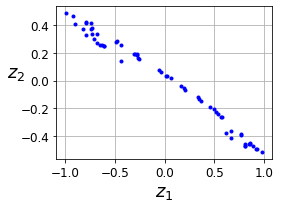

In [ ]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# 17.3 적층 오토인코더

오토인코더도 hidden layer를 여러 개 가질 수 있음(이런 경우가 적층/심층 오토인코더)

오토인코더가 너무 강력해지지 않도록 주의해야함. 강력한 오토인코더는 훈련데이터를 완벽하게 재구성하겠지만 이 과정에서 유용한 데이터 표현을 학습하지 못할 것임.

## 17.3.1 케라스를 사용하여 적층 오토인코더 구현하기

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [6]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss = 'binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.5))

history = stacked_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3374 - val_loss: 0.3180
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3049 - val_loss: 0.3011
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2981 - val_loss: 0.2980
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2941 - val_loss: 0.2940
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2914 - val_loss: 0.2913
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2894 - val_loss: 0.2897
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2878 - val_loss: 0.2889
Epoch 8/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2866 - val_loss: 0.2926
Epoch 9/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2857 - val_loss: 0.2872
Epoch 10/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.284

- 인코더는 28x28 픽셀의 흑백이미지를 받은 뒤, 크기가 점점 줄어드는 Dense 층 두개에 통과. 인코더는 각 이미지에 대해 크기가 30인 벡터를 출력

- 디코더는 크기가 30인 코딩을 받아 점점 커지는 Dense 층 두 개에 통과시키고, 최종 벡터를 28x28 배열로 변경하여 출력과 입력의 크기가 같도록 조정

## 17.3.2 재구성 시각화

In [7]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 73ms/step
그림 저장 reconstruction_plot


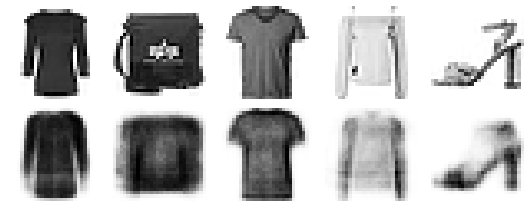

In [ ]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

재구성된 이미지를 식별할 수는 있지만 정보를 조금 많이 잃음.

## 17.3.3 패션 MNIST 데이터셋 시각화

In [ ]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 2ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


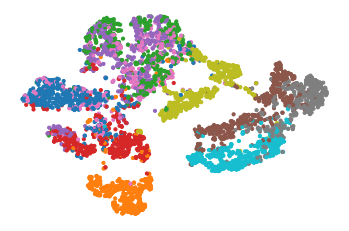

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

그림 저장 fashion_mnist_visualization_plot


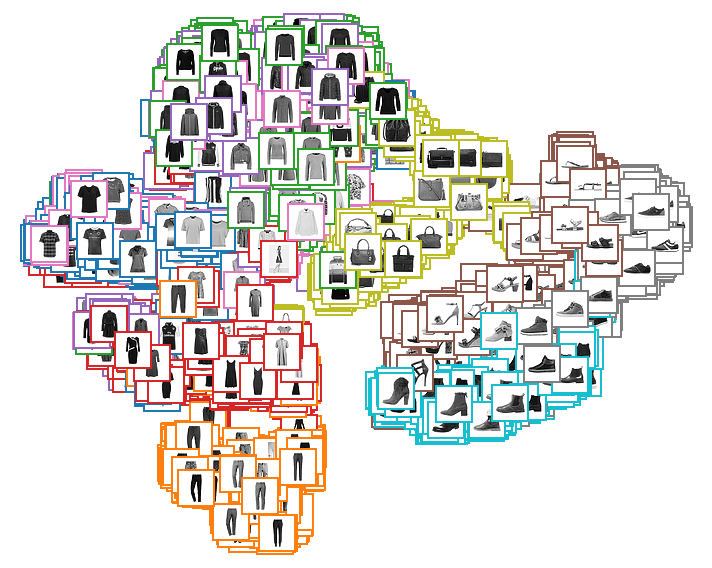

In [ ]:
# https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html 참고
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## 17.3.4 적층 오토인코더를 사용한 비지도 사전훈련

레이블된 훈련 데이터가 많지 않은 복잡한 지도학습문제를 다루어야 한다면, 비슷한 문제를 학습한 신경망을 찾아 하위층을 재사용하는 것도 한 방법



## 17.3.5 가중치 묶기

오토인코더가 완벽하게 대칭일 땐 디코더의 가중치와 인코더의 가중치를 묶는 것이 일반적.

이렇게 하면 모델에 있는 가중치의 수를 절반으로 줄임

예를 들어 어떤 오토인코더가 (입력층 제외한) N개의 층을 갖고 $W_L$이 L번째 층의 가중치를 나타낸다고 했을 때, 디코더 층의 가중치는 $W_{N-L+1} = W_L^T$로 정의

In [ ]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias', initializer='zeros', shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)

    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b = True)
        return self.activation(z + self.biases)

transpose_b = True로 지정하는 것이 다른 Dense 층의 전치된 가중치를 활용하는 방법

이 디코더의 Dense층은 인코더의 Dense층과 묶여있다

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation='selu')
dense_2 = keras.layers.Dense(30, activation='selu')

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1, 
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation='selu'),
    DenseTranspose(dense_1, activation='sigmoid'),  
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3081 - val_rounded_accuracy: 0.9078
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2975 - rounded_accuracy: 0.9224 - val_loss: 0.2951 - val_rounded_accuracy: 0.9285
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2920 - rounded_accuracy: 0.9274 - val_loss: 0.3016 - val_rounded_accuracy: 0.9090
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2889 - rounded_accuracy: 0.9302 - val_loss: 0.2880 - val_rounded_accuracy: 0.9332
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2865 - rounded_accuracy: 0.9325 - val_loss: 0.2872 - val_rounded_accuracy: 0.9317
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2850 - rounded_accuracy: 0.9340 - val_loss: 0.2861 - val_rounded_accuracy: 0.9353
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 68ms/step


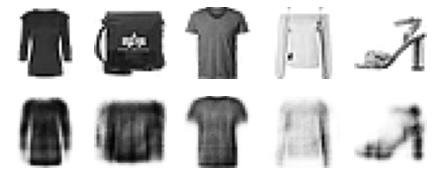

In [ ]:
show_reconstructions(tied_ae)
plt.show()

# 17.3.6 한 번에 오토인코더 한 개씩 훈련하기

전체 오토인코더를 훈련하는 것보다 오토인코더 하나를 훈련하고 이를 쌓아올려서 한 개의 적층 오토인코더를 만들 수 있음

훈련 단계 1에서 첫번째 오토인코더는 입력을 재구성하도록 학습. 다음 이 오토인코더를 사용해 전체 훈련셋을 인코딩하여 (압축된 새 훈련셋을 만듬)

이 새로운 훈련세트에서 두번째 오토인코더를 훈련(훈련단계 2)

마지막으로 모든 오토인코더를 이용해 전체 네트워크 형성

In [8]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05),
    output_activation="selu")

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.3445 - rounded_accuracy: 0.8874 - val_loss: 0.3123 - val_rounded_accuracy: 0.9146
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3039 - rounded_accuracy: 0.9203 - val_loss: 0.3006 - val_rounded_accuracy: 0.9246
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2949 - rounded_accuracy: 0.9286 - val_loss: 0.2934 - val_rounded_accuracy: 0.9317
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2891 - rounded_accuracy: 0.9342 - val_loss: 0.2888 - val_rounded_accuracy: 0.9363
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2853 - rounded_accuracy: 0.9378 - val_loss: 0.2857 - val_rounded_accuracy: 0.9392
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2827 - rounded_accuracy: 0.9403 - val_loss: 0.2834 - val_rounded_accuracy: 0.9409
Epoch 7/10
1719/1719 [=================

In [ ]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 70ms/step


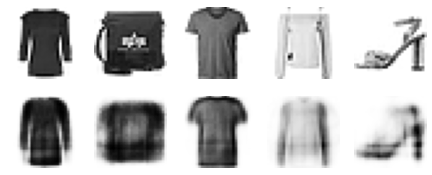

In [ ]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [ ]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2867 - rounded_accuracy: 0.9343 - val_loss: 0.2883 - val_rounded_accuracy: 0.9341
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2863 - rounded_accuracy: 0.9347 - val_loss: 0.2881 - val_rounded_accuracy: 0.9347
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2861 - rounded_accuracy: 0.9349 - val_loss: 0.2879 - val_rounded_accuracy: 0.9347
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2859 - rounded_accuracy: 0.9351 - val_loss: 0.2877 - val_rounded_accuracy: 0.9349
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2858 - rounded_accuracy: 0.9353 - val_loss: 0.2876 - val_rounded_accuracy: 0.9351
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2857 - rounded_accuracy: 0.9354 - val_loss: 0.2874 - val_rounded_accuracy: 0.9350
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 79ms/step


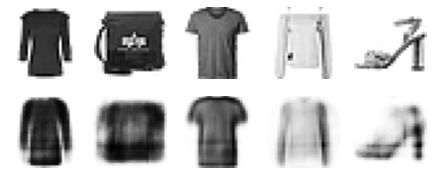

In [ ]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

# 17.4 합성곱 오토인코더

이미지를 다루는 경우에는 오토인코더가 좋은 성능을 내지 못함.

이미지를 다룰 때는 합성곱 신경망이 Dense 층보다 훨씬 잘 맞음 -> 합성곱 오토인코더

인코더는 합성곱층과 풀링층으로 구성된 일반적인 CNN, 인코더는 전형적으로 input에서 공간 방향의 차원을 줄이고 깊이를 늘림

디코더는 반대로 동장. 이미지의 스케일을 늘리고 깊이를 우너본 차원으로 되돌림
(이를 위해 전치 합성곱 층을 사용)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2)
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid', activation='selu', input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='selu'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

In [ ]:
conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 18s 6ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.2851 - val_rounded_accuracy: 0.9283
Epoch 2/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2756 - rounded_accuracy: 0.9413 - val_loss: 0.2730 - val_rounded_accuracy: 0.9452
Epoch 3/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2708 - rounded_accuracy: 0.9462 - val_loss: 0.2696 - val_rounded_accuracy: 0.9497
Epoch 4/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2682 - rounded_accuracy: 0.9490 - val_loss: 0.2685 - val_rounded_accuracy: 0.9492
Epoch 5/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2664 - rounded_accuracy: 0.9509 - val_loss: 0.2669 - val_rounded_accuracy: 0.9513


In [ ]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)         

1/1 [==============================] - 0s 201ms/step


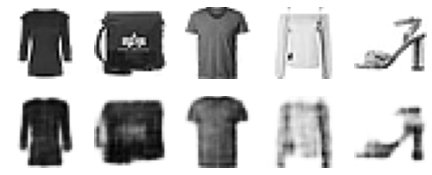

In [ ]:
show_reconstructions(conv_ae)
plt.show()

# 17.5 순환 오토인코더

시계열이나 텍스트와 같은 시퀀스에 대한 오토인코더를 만들려면 순환 신경망이 Dense 층보다 나을 수 있음.

Recurrent Autoencoder의 인코더는 일반적으로 seq2vec RNN이고, 디코더는 vec2seq RNN

In [ ]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[None, 28]),
    keras.layers.LSTM(30)
])

recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation='sigmoid'))
])

recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

In [ ]:
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 29s 13ms/step - loss: 0.5192 - rounded_accuracy: 0.7492 - val_loss: 0.4581 - val_rounded_accuracy: 0.8081
Epoch 2/10
1719/1719 [==============================] - 20s 11ms/step - loss: 0.4051 - rounded_accuracy: 0.8432 - val_loss: 0.3744 - val_rounded_accuracy: 0.8681
Epoch 3/10
1719/1719 [==============================] - 22s 13ms/step - loss: 0.3653 - rounded_accuracy: 0.8710 - val_loss: 0.3603 - val_rounded_accuracy: 0.8769
Epoch 4/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3507 - rounded_accuracy: 0.8809 - val_loss: 0.3523 - val_rounded_accuracy: 0.8773
Epoch 5/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.3405 - rounded_accuracy: 0.8875 - val_loss: 0.3362 - val_rounded_accuracy: 0.8924
Epoch 6/10
1719/1719 [==============================] - 20s 11ms/step - loss: 0.3334 - rounded_accuracy: 0.8923 - val_loss: 0.3307 - val_rounded_accuracy: 0.8959
Epoch 7/10
1719/1719 [======

1/1 [==============================] - 1s 1s/step


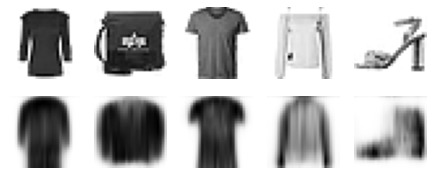

In [ ]:
show_reconstructions(recurrent_ae)
plt.show()

# 17.6 잡음 제거 오토인코더

오토인코더가 유용한 특성을 학습하도록 강제하는 다른 방법은 입력에 잡음을 추가하고, 잡음이 없는 원본 입력을 복원하도록 훈련

적층 잡음제거 오토인코더(stacked denoising autoencoder)

In [ ]:
# 가우시안 잡음 추가한 버전
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.3500 - rounded_accuracy: 0.8773 - val_loss: 0.3166 - val_rounded_accuracy: 0.9078
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3120 - rounded_accuracy: 0.9097 - val_loss: 0.3089 - val_rounded_accuracy: 0.9153
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3060 - rounded_accuracy: 0.9148 - val_loss: 0.3033 - val_rounded_accuracy: 0.9179
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3025 - rounded_accuracy: 0.9179 - val_loss: 0.2999 - val_rounded_accuracy: 0.9218
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2996 - rounded_accuracy: 0.9205 - val_loss: 0.2973 - val_rounded_accuracy: 0.9238
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2974 - rounded_accuracy: 0.9223 - val_loss: 0.2959 - val_rounded_accuracy: 0.9267
Epoch 7/10
1719/1719 [=================

1/1 [==============================] - 0s 58ms/step


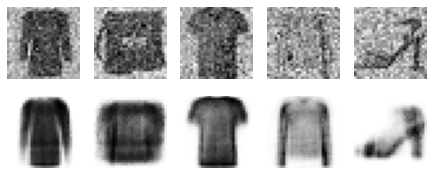

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

In [ ]:
# 드롭아웃으로 잡음 추가한 버전
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3568 - rounded_accuracy: 0.8710 - val_loss: 0.3200 - val_rounded_accuracy: 0.9041
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3125 - val_rounded_accuracy: 0.9110
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3128 - rounded_accuracy: 0.9075 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3092 - rounded_accuracy: 0.9102 - val_loss: 0.3041 - val_rounded_accuracy: 0.9178
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3067 - rounded_accuracy: 0.9123 - val_loss: 0.3015 - val_rounded_accuracy: 0.9193
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3048 - rounded_accuracy: 0.9139 - val_loss: 0.3014 - val_rounded_accuracy: 0.9173
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 67ms/step
그림 저장 dropout_denoising_plot


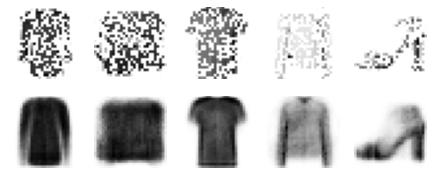

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

# 17.7 희소 오토인코더

희소(sparsity) - 좋은 특성을 추출하도록 만드는 다른 방식의 제약

비용함수에 적절한 항을 추가하여 오토인코더가 코딩 층에서 활성화되는 뉴런 수를 감소시키도록 만듬

희소한 뉴런만 활성화되기 때문에 적은 뉴런으로도 유용한 특성을 표현하도록 학습되어, 전체적으로 종합해보았을 때 훨씬 유용해짐

간단한 방법은 코딩층에 시그모이드 활성화 함수를 사용하고 큰 코딩층을 사용하며, L1 규제를 추가

In [9]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [10]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

In [ ]:
# 시그모이드 함수만 추가한 버전

tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.4329 - rounded_accuracy: 0.7950 - val_loss: 0.3773 - val_rounded_accuracy: 0.8492
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3612 - rounded_accuracy: 0.8668 - val_loss: 0.3514 - val_rounded_accuracy: 0.8797
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3410 - rounded_accuracy: 0.8852 - val_loss: 0.3367 - val_rounded_accuracy: 0.8912
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3288 - rounded_accuracy: 0.8954 - val_loss: 0.3263 - val_rounded_accuracy: 0.8991
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3213 - rounded_accuracy: 0.9011 - val_loss: 0.3210 - val_rounded_accuracy: 0.9032
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3176 - rounded_accuracy: 0.9038 - val_loss: 0.3179 - val_rounded_accuracy: 0.9050
Epoch 7/10
1719/1719 [============

1/1 [==============================] - 0s 103ms/step


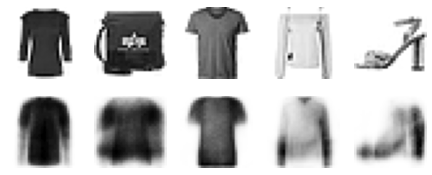

In [ ]:
show_reconstructions(simple_ae)
plt.show()

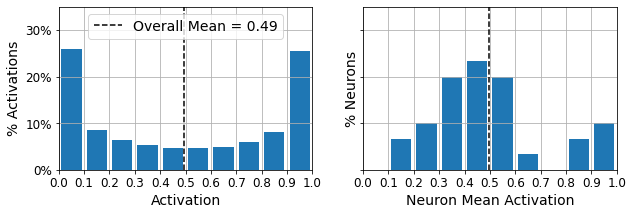

In [ ]:
# 대부분의 뉴런은 0.5정도로 작동하지만 매번 작동하는 뉴런도 존재

plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

In [ ]:
# L1 규제 + 큰 코딩 층 추가
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(300, activation='sigmoid'),
    keras.layers.ActivityRegularization(l1=1e-3)
     # 입력을 그대로 반환하면서 훈련 손실에 입력의 절댓값의 합을 더함
])

sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[300]),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])

In [ ]:
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4310 - rounded_accuracy: 0.8129 - val_loss: 0.3808 - val_rounded_accuracy: 0.8555
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3690 - rounded_accuracy: 0.8689 - val_loss: 0.3638 - val_rounded_accuracy: 0.8741
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3545 - rounded_accuracy: 0.8799 - val_loss: 0.3502 - val_rounded_accuracy: 0.8857
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3418 - val_rounded_accuracy: 0.8898
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3372 - rounded_accuracy: 0.8920 - val_loss: 0.3368 - val_rounded_accuracy: 0.8949
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3320 - rounded_accuracy: 0.8968 - val_loss: 0.3316 - val_rounded_accuracy: 0.8992
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 73ms/step


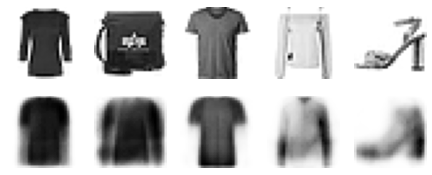

In [ ]:
show_reconstructions(sparse_l1_ae)

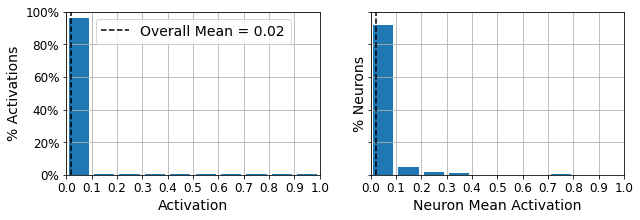

In [ ]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

더 나은 결과를 내는 방법은 훈련반복마다 코딩 층의 실제 희소 정도를 측정하고 측정된 희소 정도가 타깃 희소정도와 다르면 모델에 규제를 가하는 것.

이를 위해 각 뉴런의 평균적인 활성화를 계산

각 뉴런에 대한 평균 활성화 정도를 알면 비용함수에 희소 손실(sparsity loss)를 추가하여 너무 활성화되거나 활성화되지 않은 뉴런에 벌을 가할 수 있음

효과적인 방법으로는 MSE보다 더 강한 그레이디언트를 가진 쿨백-라이블러 발산(Kullback-Leibler divergence)를 사용

그림 저장 sparsity_loss_plot


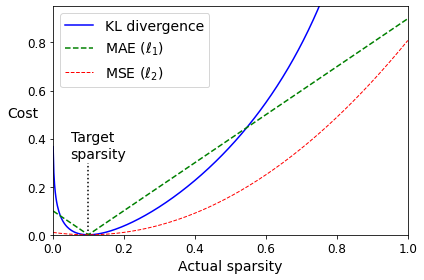

In [ ]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

- 쿨백-라이블러 발산\
$D_{KL}(P||L) = \sum_i P(i) log {P(i) \over Q(i)}$

- 목표 희소정도 p와 실제 희소정도 q 사이의 KL 발산
$D_{KL}(p||q) = plog{p \over q} + (1-p) log {1-p \over 1-q}$

In [ ]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4150 - rounded_accuracy: 0.8121 - val_loss: 0.3716 - val_rounded_accuracy: 0.8564
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3531 - rounded_accuracy: 0.8763 - val_loss: 0.3442 - val_rounded_accuracy: 0.8847
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3340 - rounded_accuracy: 0.8918 - val_loss: 0.3293 - val_rounded_accuracy: 0.8975
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3224 - rounded_accuracy: 0.9018 - val_loss: 0.3213 - val_rounded_accuracy: 0.9043
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3169 - rounded_accuracy: 0.9063 - val_loss: 0.3171 - val_rounded_accuracy: 0.9078
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3135 - rounded_accuracy: 0.9093 - val_loss: 0.3140 - val_rounded_accuracy: 0.9105
Epoch 7/10
1719/1719 [==============

1/1 [==============================] - 0s 302ms/step


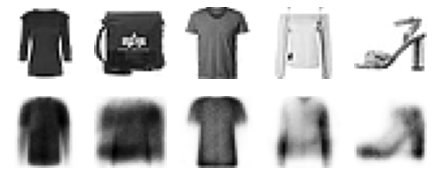

In [ ]:
show_reconstructions(sparse_kl_ae)

그림 저장 sparse_autoencoder_plot


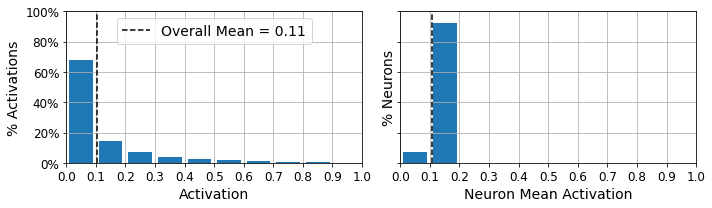

In [ ]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show()

# 17.8 변이형 오토인코더

변이형 오토인코더는 다음과 같은 점에서 기존의 오토인코더와의 차별점 존재
- 확률적 오토인코더 : 훈련이 끝난 후에도 출력이 부분적으로 확률에 의해 결정
- 생성 오토인코더 : 새로운 샘플을 생성

오토인코더의 기본구조인 인코더와 디코더가 있는데, 다른점은 주어진 입력에 대한 코딩을 바로 만드는 대신 인코더는 평균 코딩 $\mu$와 $\sigma$를 만듬.

실제 코딩은 평균이 $\mu$이고 분산이 $\sigma$인 가우시안 분포에서 랜덤하게 샘플링

그 후 디코더가 샘플링 된 코딩을 보통처럼 디코딩

훈련하는 동안 비용함수가 코딩을 가우시안 샘플들의 군집처럼 보이도록 코딩 공간(잠재 공간)안으로 점진적으로 이동 -> 변이형 오토인코더는 훈련이 끝난 뒤 새로운 샘플을 매우 쉽게 생성

비용함수는 두 부분으로 구성.
- 재구성 손실 : 오토 인코더가 입력을 재생산하도록 만드는 손실
- 잠재 손실 : 가우시안 분포에서 샘플된 것 같은 코딩을 가지도록 오토인코더를 강제. 목표 분포와 실제 코딩분포사이의 KL 발산을 사용

- 변이형 오토인코더의 잠재 손실\
$L = -{1\over2} \sum_{i=1}^n 1 + log(\sigma_i^2) -\sigma_i^2 - \mu_i^2  $

- log($\sigma^2$)을 사용해 다시 쓴 변이형 오토인코더의 잠재손실\
$L = -{1\over2} \sum_{i=1}^n 1 + \gamma_i - exp(\gamma_i) - \mu_i^2$

In [ ]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 5s 10ms/step - loss: 0.3894 - rounded_accuracy: 0.8609 - val_loss: 0.3502 - val_rounded_accuracy: 0.8969
Epoch 2/25
430/430 [==============================] - 3s 7ms/step - loss: 0.3423 - rounded_accuracy: 0.8981 - val_loss: 0.3394 - val_rounded_accuracy: 0.9046
Epoch 3/25
430/430 [==============================] - 3s 7ms/step - loss: 0.3326 - rounded_accuracy: 0.9054 - val_loss: 0.3338 - val_rounded_accuracy: 0.9068
Epoch 4/25
430/430 [==============================] - 3s 7ms/step - loss: 0.3278 - rounded_accuracy: 0.9091 - val_loss: 0.3293 - val_rounded_accuracy: 0.9065
Epoch 5/25
430/430 [==============================] - 3s 7ms/step - loss: 0.3247 - rounded_accuracy: 0.9118 - val_loss: 0.3296 - val_rounded_accuracy: 0.9103
Epoch 6/25
430/430 [==============================] - 3s 7ms/step - loss: 0.3225 - rounded_accuracy: 0.9137 - val_loss: 0.3277 - val_rounded_accuracy: 0.9052
Epoch 7/25
430/430 [==============================]

1/1 [==============================] - 0s 108ms/step


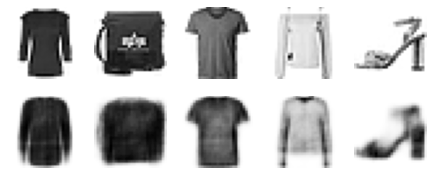

In [ ]:
show_reconstructions(variational_ae)
plt.show()

## 17.8.1 패션 MNIST 이미지 생성

In [11]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

그림 저장 vae_generated_images_plot


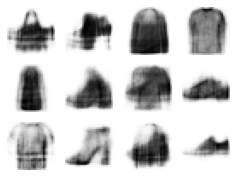

In [ ]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

변이형 오토인코더는 semantic interpolation을 수행할 수 있음. 코딩수준에서 두 이미지를 보간

그림 저장 semantic_interpolation_plot


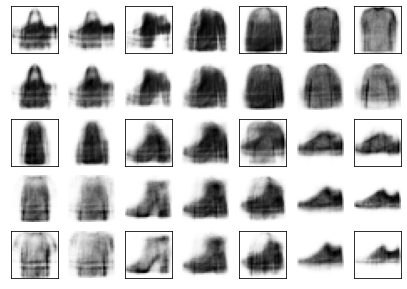

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

# 17.9 생성적 적대 신경망

판별자/생성자 신경망을 서로 겨루게 하고 경쟁을 통해 신경망을 향상하는 것을 기대

- 생성자 : 랜덤한 분포(일반적으로 가우시안)를 입력으로 받고 이미지와 같은 데이터를 출력

- 판별자 : 생성자에서 얻은 가짜 이미지나 훈련 셋에서 추출한 진짜 이미지를 입력으로 받아 입력된 이미지가 진짜인지 가짜인지 구분

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[codings_size]),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(1, activation='sigmoid')
])

gan = keras.models.Sequential([generator, discriminator])

In [14]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")     # 판별자 또한 이진분류기이므로 한번 컴파일 진행
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [15]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/1


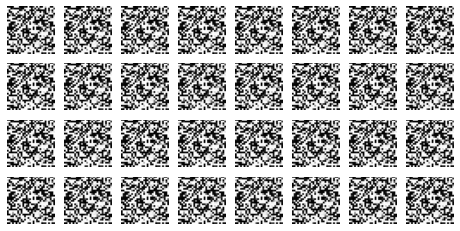

In [18]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # 단계 1 - 판별자 훈련
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable=True
            discriminator.train_on_batch(X_fake_and_real, y1)

            # 단계 2 - 생성자 훈련
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable=False
            gan.train_on_batch(noise, y2)

        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()  

train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

- 첫번째 단계에서 가우시안 잡음을 생성자에 주입하여 가짜 이미지를 생성. 타깃 y1은 가짜 이미지일 경우 0이고 진짜 이미지는 1로 설정.

- 두번째 단계에서 GAN에 가우시안 잡음을 주입. 생성자가 먼저 가짜 임지ㅣ를 생성하고 판별자가 이 이미지가 가짜인지 진짜인지 추측

그림 저장 gan_generated_images_plot


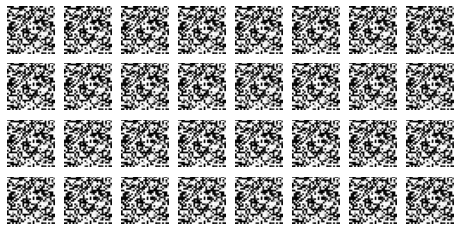

In [19]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)

그림 저장 gan_generated_images_plot


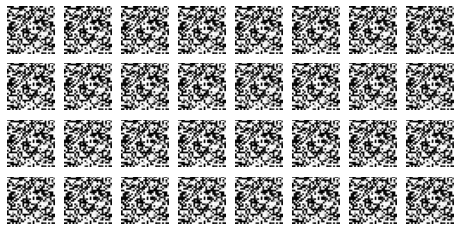

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)

In [21]:
train_gan(gan, dataset, batch_size, codings_size)

Output hidden; open in https://colab.research.google.com to view.

## 17.9.1 GAN 훈련의 어려움

훈련 과정에서 생성자와 판별자는 끊임없이 서로 앞서려고 노력하기 때문에, 내시 균형이라 부르는 상태에 다다를 수 있음(전략을 수정하지 않는 상태)

GAN을 충분히 훈련하면 이 내쉬균형에 도달할 수 있지만 그렇게 쉽지는 않다.

가장 큰 어려움은 mode collapse(생성자의 출력의 다양성이 줄어들 때)

생성자가 다른 이미지보다 신발을 더 잘 만든다고 했을 때, 신발이 더 판별자를 속이기 쉽기 때문에 신발만 만들게 되며, 그에 따라 다른 이미지를 만드는 방법을 잊음

이러한 문제를 해결하기 위해 experience replay, mini-batch discrimination과 같은 방법이 제안. 아직까진 연구중

## 17.9.2 심층 합성곱 GAN

- (판별자에 있는) 풀링층을 스트라이드 합성곱으로 바꾸고 (생성자에 있는) 풀링층은 전치 합성곱으로 바꿈
- 생성자와 판별자에 배치정규화를 사용, 생성자의 출력층과 판별자의 입력층은 제외
- 층을 깊게 쌓기 위해 완전 연결 은닉층을 제거
- tanh 함수를 사용해야 하는 출력층을 제외하고 생성자의 모든 층은 ReLU 활성화 함수를 사용
- 판별자의 모든 층은 LeakyReLU 활성화 함수를 사용

In [25]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7*7*128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh')
])

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation=keras.layers.LeakyReLU(0.2), input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same', activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

gan = keras.models.Sequential([generator, discriminator])

In [26]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [27]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [28]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [29]:
train_gan(gan, dataset, batch_size, codings_size)

Output hidden; open in https://colab.research.google.com to view.

그림 저장 dcgan_generated_images_plot


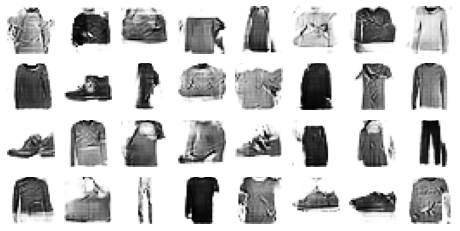

In [30]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)